In [3]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
import numpy as np
import pandas as pd
import polars as pl
import pymc as pm
import pytensor as pt
import pybaseball 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_SEED = 504

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v5.19.1


In [15]:
pt.config.cxx = none

In [ ]:
from retrieve_sql_module import get_table

fangraphs_batting_stats_2024 = get_table("fangraphs_batting_stats_2024")

In [3]:
fitting_subset = (
    fangraphs_batting_stats_2024
    .assign(
        label=lambda df: df["Name"].astype(str) + " - " + 
                         df["Season"].astype(str) + " - " + 
                         df["Team"].astype(str)
    )
)

In [4]:
fitting_subset

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR,label
0,15640,2024,Aaron Judge,NYY,32,158,559,704,180,85,...,238,0.609,391,0.146,0.267,0.315,0.742,0.484,11.3,Aaron Judge - 2024 - NYY
1,25764,2024,Bobby Witt Jr.,KCR,24,161,636,709,211,123,...,259,0.481,538,0.138,0.236,0.321,0.594,0.413,10.0,Bobby Witt Jr. - 2024 - KCR
2,19755,2024,Shohei Ohtani,LAD,29,159,636,731,197,98,...,287,0.595,482,0.144,0.269,0.320,0.678,0.448,9.0,Shohei Ohtani - 2024 - LAD
3,20123,2024,Juan Soto,NYY,25,157,576,713,166,90,...,262,0.568,461,0.189,0.263,0.319,0.658,0.463,8.2,Juan Soto - 2024 - NYY
4,26289,2024,Gunnar Henderson,BAL,23,159,630,719,177,102,...,256,0.539,475,0.167,0.265,0.289,0.505,0.379,7.7,Gunnar Henderson - 2024 - BAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,6887,2024,Martin Maldonado,CHW,37,48,135,147,16,9,...,31,0.356,87,0.194,0.360,0.160,0.295,0.223,-1.3,Martin Maldonado - 2024 - CHW
636,15676,2024,Jose Abreu,HOU,37,35,113,120,14,10,...,28,0.326,86,0.173,0.298,0.162,0.241,0.199,-1.5,Jose Abreu - 2024 - HOU
637,20543,2024,Elehuris Montero,COL,25,67,224,247,46,32,...,71,0.415,171,0.132,0.290,0.212,0.338,0.274,-1.8,Elehuris Montero - 2024 - COL
638,12155,2024,Eddie Rosario,- - -,32,91,297,319,52,30,...,96,0.425,226,0.146,0.281,0.212,0.345,0.259,-2.3,Eddie Rosario - 2024 - - - -


In [5]:
fitting_subset['hr_rate'] = fitting_subset['HR'] / fitting_subset['PA']

In [6]:
fitting_subset.sort_values(by="hr_rate", ascending = False).head(5)

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR,label,hr_rate
305,19273,2024,Stone Garrett,WSN,28,2,5,6,3,1,...,0.800,5,0.032,0.129,0.602,1.390,0.799,0.3,Stone Garrett - 2024 - WSN,0.166667
349,25448,2024,Greg Jones,COL,26,6,5,6,1,0,...,1.000,1,0.103,0.310,0.199,0.791,0.448,0.1,Greg Jones - 2024 - COL,0.166667
294,25705,2024,Dustin Harris,TEX,24,2,6,7,2,0,...,0.750,4,0.174,0.304,0.285,0.512,0.385,0.2,Dustin Harris - 2024 - TEX,0.142857
426,19928,2024,Ryan McKenna,- - -,27,13,14,15,3,1,...,0.444,9,0.115,0.212,0.169,0.383,0.260,-0.1,Ryan McKenna - 2024 - - - -,0.133333
239,27493,2024,Rece Hinds,CIN,23,24,46,51,12,2,...,0.400,30,0.114,0.310,0.254,0.625,0.396,0.6,Rece Hinds - 2024 - CIN,0.098039


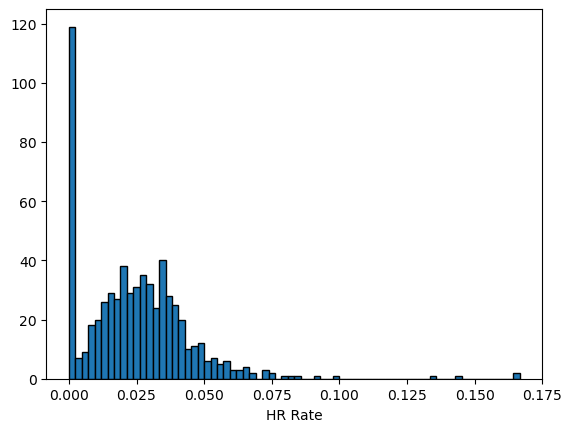

In [7]:
plt.hist(fitting_subset['hr_rate'].dropna(), bins = 70, edgecolor='black')
plt.xlabel("HR Rate")
plt.show()

In [8]:
pa, hr = fitting_subset[["PA", "HR"]].astype(np.int32).to_numpy().T
coords = {"batter":fitting_subset[['label']].to_numpy().squeeze()}

In [9]:
with pm.Model(coords=coords) as uninformative_prior_model:

    p = pm.Uniform("p", 0, 1, dims = "batter")

    y = pm.Binomial("y", n = pa, p = p, observed = hr, dims="batter")
pm.model_to_graphviz(uninformative_prior_model)


You can find the C code in this temporary file: C:\Users\jamin\AppData\Local\Temp\pytensor_compilation_error_39224rx3


CompileError: Compilation failed (return status=1):
"C:\MinGW\bin\g++.EXE" -shared -g -Wno-c++11-narrowing -fno-exceptions -fno-unwind-tables -fno-asynchronous-unwind-tables -DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -m64 -DMS_WIN64 -I"C:\Users\jamin\anaconda3\envs\pymc_env\Lib\site-packages\numpy\core\include" -I"C:\Users\jamin\anaconda3\envs\pymc_env\include" -I"C:\Users\jamin\anaconda3\envs\pymc_env\Lib\site-packages\pytensor\link\c\c_code" -L"C:\Users\jamin\anaconda3\envs\pymc_env\libs" -L"C:\Users\jamin\anaconda3\envs\pymc_env" -o "C:\Users\jamin\AppData\Local\PyTensor\compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_167_Stepping_1_GenuineIntel-3.12.8-64\lazylinker_ext\lazylinker_ext.pyd" "C:\Users\jamin\AppData\Local\PyTensor\compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_167_Stepping_1_GenuineIntel-3.12.8-64\lazylinker_ext\mod.cpp" "C:\Users\jamin\anaconda3\envs\pymc_env\python312.dll"
C:\Users\jamin\AppData\Local\PyTensor\compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_167_Stepping_1_GenuineIntel-3.12.8-64\lazylinker_ext\mod.cpp:1:0: sorry, unimplemented: 64-bit mode not compiled in
 #include "pytensor_mod_helper.h"
 
